In [1]:
import os
from pathlib import Path
import sys
curdir = Path(os.getcwd())
sys.path.append(str(curdir.parent.absolute()))
from collections import Counter
import pandas as pd
from protnote.utils.data import read_fasta,save_to_fasta
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import re
import obonet
import umap
import numpy as np
from sklearn.preprocessing import StandardScaler
from protnote.utils.data import generate_vocabularies
from scipy.stats import spearmanr,pearsonr
import matplotlib.colors as mcolors
from protnote.utils.data import get_ec_class_descriptions,read_json
from sklearn.metrics.pairwise import pairwise_distances 
from scipy.stats import ttest_ind
from itertools import product
from protnote.utils.notebooks import *

ec_class_descriptions = get_ec_class_descriptions('../data/annotations/enzclass.txt')
ontology2alias = {'molecular_function':'MF','biological_process':'BP','cellular_component':'CC','All':'All'}
graph = obonet.read_obo('../data/annotations/go_2024-06-17.obo')
parenthood_2019 = read_json('../data/vocabularies/parenthood_jul_2019.json')
plt.rcParams['font.size'] = 14
os.makedirs('../outputs/figures',exist_ok=True)

/home/samirchar/miniconda3/envs/protnote/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/samirchar/miniconda3/envs/protnote/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/samirchar/miniconda3/envs/protnote/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Embeddings (fig 3 and S7)

Declaring constants

In [2]:
embeddings = torch.load('../outputs/results/test_1_embeddings_TEST_TOP_LABELS_DATA_PATH_seed_replicates_v9_42_sum_last_epoch/batches_0_99.pt',
               map_location='cpu')

num_seqs = 800
num_labels = embeddings['labels'].shape[-1]
vocab = generate_vocabularies('../data/swissprot/proteinfer_splits/random/test_top_labels_GO.fasta')['label_vocab']
graph_2019 = obonet.read_obo('../data/annotations/go_2019-07-01.obo')
vocab_parents = [(graph_2019.nodes[go_term]["namespace"] if  go_term in graph_2019.nodes else 'missing') for go_term in vocab]
joint_embedding_dim = embeddings['joint_embeddings'].shape[-1]


### Sequence embedding and label correlations

/home/samirchar/miniconda3/envs/protnote/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)




label sim = jaccard_sim, seqs sim = cos_sim
pearson = PearsonRResult(statistic=0.5330794850656138, pvalue=0.0), spearman = SignificanceResult(statistic=0.3153036749464395, pvalue=0.0) 




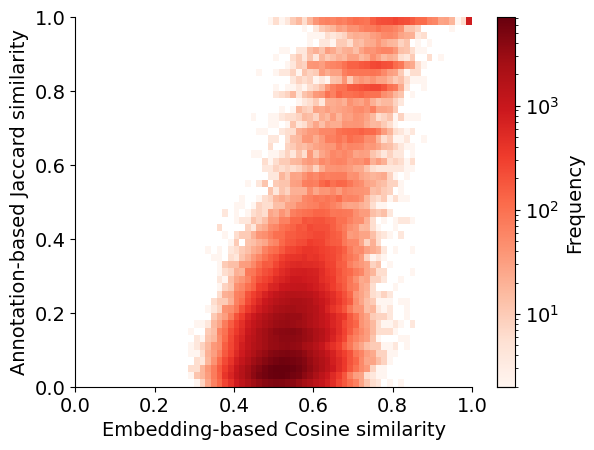



label sim = cos_sim, seqs sim = cos_sim
pearson = PearsonRResult(statistic=0.40405867344032304, pvalue=0.0), spearman = SignificanceResult(statistic=0.3398965705579301, pvalue=0.0) 




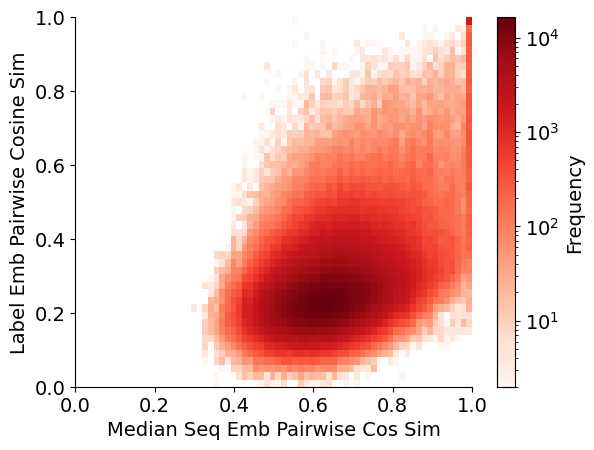

In [3]:
# Correlation between embedding similarty and annotation-based similiary with Jaccard dist.
seq_embeddings = embeddings['joint_embeddings'][range(0,num_labels*num_seqs,num_labels),:joint_embedding_dim//2]
labels = embeddings['labels']


label_similarities = {
    'jaccard_sim':1 - pairwise_distances(X=labels, metric="jaccard", n_jobs=-1)
    }

sequence_similarities = {
    'cos_sim': 1 - pairwise_distances(X=seq_embeddings, metric="cosine", n_jobs=-1)
                }

for seq_sims,label_sims in zip(sequence_similarities.items(),label_similarities.items()):
    spearman = spearmanr(seq_sims[1].flatten(),label_sims[1].flatten())
    pearson = pearsonr(seq_sims[1].flatten(),label_sims[1].flatten())
    print('\n')
    print(f'label sim = {label_sims[0]}, seqs sim = {seq_sims[0]}')
    print(f'pearson = {pearson}, spearman = {spearman} ')
    print('\n')


    plt.hist2d(x=seq_sims[1].flatten(),y=label_sims[1].flatten(), bins=50, cmap='Reds',norm=mcolors.LogNorm())
    plt.colorbar(label='Frequency')
    sns.despine()
    plt.xlabel('Embedding-based Cosine similarity')
    plt.ylabel('Annotation-based Jaccard similarity')
    plt.xlim(0,1)
    plt.ylim(0,1)
    save_fig("../outputs/figures/seq_embeddings_2d_hist")
    plt.show()


    
#Get a sequence representation as the median embedding of their positive annotations. 
#Compute correlation with pairwise label emedding similarity
label_embeddings = embeddings['joint_embeddings'][:num_labels,joint_embedding_dim//2:]
label_mask = (labels.T.sum(axis=1)!=0)

agg_seq_embeddings = np.vstack([np.median(seq_embeddings[labels.T[i].astype(bool)],axis=0) for i in range(len(labels.T)) if labels.T[i].sum()>0])

label_similarities = {
    'cos_sim': 1 - pairwise_distances(X=label_embeddings[label_mask], metric="cosine", n_jobs=-1)
    }

sequence_similarities = {
    'cos_sim': 1 - pairwise_distances(X=agg_seq_embeddings, metric="cosine", n_jobs=-1)
                }

for seq_sims,label_sims in zip(sequence_similarities.items(),label_similarities.items()):
    spearman = spearmanr(seq_sims[1].flatten(),label_sims[1].flatten())
    pearson = pearsonr(seq_sims[1].flatten(),label_sims[1].flatten())
    print('\n')
    print(f'label sim = {label_sims[0]}, seqs sim = {seq_sims[0]}')
    print(f'pearson = {pearson}, spearman = {spearman} ')
    print('\n')

    plt.hist2d(x=seq_sims[1].flatten(),y=label_sims[1].flatten(), bins=50, cmap='Reds',norm=mcolors.LogNorm())
    plt.colorbar(label='Frequency')
    sns.despine()
    plt.ylabel('Label Emb Pairwise Cosine Sim')
    plt.xlabel('Median Seq Emb Pairwise Cos Sim')
    plt.xlim(0,1)
    plt.ylim(0,1)
    save_fig("../outputs/figures/label_embeddings_2d_hist")
    plt.show()



### UMAP Output layer embeddings

Warning: the following code block consumes about 110GB of memory and takes 1h+ on machine with 24 cores and 216GB of RAM.


In [ ]:

X = embeddings['output_layer_embeddings'][:num_labels*num_seqs,:]
sc = StandardScaler()
X_s = sc.fit_transform(X)

hue = vocab_parents*(num_seqs)
mask = [i !='missing' for i in hue]
hue_masked =[hue_val for hue_val,mask_val in zip(hue,mask) if mask_val]
match_binary_mask = embeddings['labels'][:num_seqs,:].flatten()

palette = sns.color_palette("tab10")

# output layer showing separation between matching and un-matching protein-function pairs
fig = plt.figure(figsize=(7,7))
X_r = umap.UMAP(
        n_neighbors=200,
        min_dist=0.3).fit(X_s).embedding_
palette_ = palette[7:8] + palette[6:7]
sns.scatterplot(x=X_r[:,0],y=X_r[:,1],marker='.',s = 2, hue=match_binary_mask,edgecolor=None,palette=palette_)
plt.legend(markerscale=10,title="Protein-Function Label", bbox_to_anchor=(0.5, -0.2), loc='upper center')
sns.despine()
plt.title('Match vs Not-Match')
save_fig('..outputs/results/match_vs_notmatch')
plt.show()


# Positive pairs of output layer colored by GO Top hierarchy
fig = plt.figure(figsize=(7,7))
palette_ = palette[4:5] + palette[8:10]
match_binary_mask = match_binary_mask.astype(bool) & mask
X_r = umap.UMAP(
    n_neighbors=50,
    min_dist=0.5).fit(X_s[match_binary_mask]).embedding_
sns.scatterplot(x=X_r[:,0],
                y=X_r[:,1],
                marker='.',
                hue=[hue_val for hue_val,mask_val,binary_mask_val in zip(hue,mask,match_binary_mask) if mask_val & binary_mask_val],
                s=15,
                edgecolor=None,
                palette=palette_)
plt.legend(markerscale=1,title="Ontology", bbox_to_anchor=(0.5, -0.2), loc='upper center')
sns.despine()
plt.title("Zoom into positive pairs, colored by GO Ontologies")
save_fig('../outputs/results/positives_by_ontology')
plt.show()



# Explore Datasets

In [10]:
train = read_fasta('../data/swissprot/proteinfer_splits/random/train_GO.fasta')
val = read_fasta('../data/swissprot/proteinfer_splits/random/dev_GO.fasta')
test = read_fasta('../data/swissprot/proteinfer_splits/random/test_GO.fasta')
zero_shot = read_fasta('../data/zero_shot/GO_swissprot_jul_2024.fasta')
zero_shot_ln = read_fasta('../data/zero_shot/GO_swissprot_leaf_nodes_jul_2024.fasta')

for dataset in ['train','val','test','zero_shot','zero_shot_ln']:
    exec(f'{dataset} = [(seq,id," ".join(labels),"{dataset}") for seq,id,labels in {dataset}]')

df = train + val + test + zero_shot + zero_shot_ln
df = pd.DataFrame(df,columns=['sequence','id','labels','split'])

In [11]:
num_sequences = len(df)
print('number of sequences:',num_sequences)

number of sequences: 588646


Distribution of the number of annotations per sequence

In [12]:
df['num_pos'] = df['labels'].str.split(' ').str.len()
df['num_pos'].describe()

count    588646.000000
mean         42.569031
std          39.031880
min           1.000000
25%          17.000000
50%          39.000000
75%          56.000000
max        1008.000000
Name: num_pos, dtype: float64

Distribution of the number of sequences per label

In [13]:
vocab,amino_freq,labels = get_data_distributions(df[df['split']=='train'])
print('# GO Terms:',len(labels.keys()),'\n')

print('GO Terms distribution:')
go_term_distribution = pd.Series(labels.values(),index=labels.keys()).sort_values(ascending=False)
go_term_distribution.describe()

# GO Terms: 31365 

GO Terms distribution:


count     31365.000000
mean        635.987821
std        7372.964658
min           1.000000
25%           4.000000
50%          14.000000
75%          70.000000
max      369909.000000
dtype: float64

Sequence length distribution

In [14]:
print('Sequence length distribution:')
print(df['sequence'].apply(len).describe())
print(df['sequence'].apply(len).quantile(.99))

Sequence length distribution:
count    588646.000000
mean        370.094289
std         345.116551
min           2.000000
25%         178.000000
50%         303.000000
75%         458.000000
max       35213.000000
Name: sequence, dtype: float64
1534.0


GO Term distribution (fig S8)

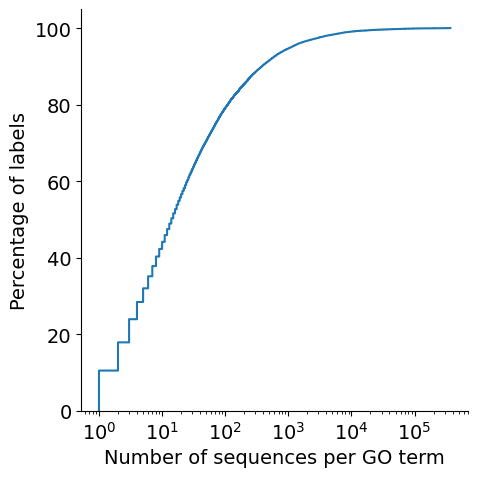

In [15]:
go_dist = go_term_distribution.reset_index().rename(columns={'index':'GO term',0:'Number of sequences per GO term'})
sns.displot(data=go_dist,x='Number of sequences per GO term',log_scale=True,kind='ecdf',stat='percent')
plt.ylabel('Percentage of labels')
save_fig('../outputs/figures/GO Term Distribution')
plt.show()

# Zero Shot Performance

Read predictions and labels for the different datasets

In [17]:
seeds = [12,22,32,42,52]
model_checkpoint = 'seed_replicates_v9_12_sum_last_epoch'

zero_shot_labels = {'TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES':('Leaf Nodes',pd.read_hdf(f'../outputs/results/test_1_labels_TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES_{model_checkpoint}.h5',key='labels_df')),
                    'TEST_DATA_PATH_ZERO_SHOT':('Leaf Nodes + Inferred',pd.read_hdf(f'../outputs/results/test_1_labels_TEST_DATA_PATH_ZERO_SHOT_{model_checkpoint}.h5',key='labels_df')),
                    'TEST_EC_DATA_PATH_ZERO_SHOT':('EC Zero Shot',pd.read_hdf(f'../outputs/results/test_1_labels_TEST_EC_DATA_PATH_ZERO_SHOT_{model_checkpoint}.h5',key='labels_df'))
                    }

zero_shot_predictions = {'Ours':{'TEST_DATA_PATH_ZERO_SHOT':[pd.read_hdf(f"../outputs/results/test_1_logits_TEST_DATA_PATH_ZERO_SHOT_seed_replicates_v9_{seed}_sum_last_epoch.h5",key='logits_df') for seed in seeds],
                                 'TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES':[pd.read_hdf(f"../outputs/results/test_1_logits_TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES_seed_replicates_v9_{seed}_sum_last_epoch.h5",key='logits_df') for seed in seeds],
                                  'TEST_EC_DATA_PATH_ZERO_SHOT':[pd.read_hdf(f"../outputs/results/test_1_logits_TEST_EC_DATA_PATH_ZERO_SHOT_seed_replicates_v9_{seed}_sum_last_epoch.h5",key='logits_df') for seed in seeds]
                                 },
                          'baseline_e5':{'TEST_DATA_PATH_ZERO_SHOT':[pd.read_hdf("../outputs/results/test_logits_GO_TEST_DATA_PATH_ZERO_SHOT_E5_baseline.h5",key='logits_df')],
                                        'TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES':[pd.read_hdf("../outputs/results/test_logits_GO_TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES_E5_baseline.h5",key='logits_df')],
                                        'TEST_EC_DATA_PATH_ZERO_SHOT':[pd.read_hdf("../outputs/results/test_logits_EC_TEST_EC_DATA_PATH_ZERO_SHOT_E5_baseline.h5",key='logits_df')]
                                 },
                           'baseline_biogpt':{'TEST_DATA_PATH_ZERO_SHOT':[pd.read_hdf("../outputs/results/test_logits_GO_TEST_DATA_PATH_ZERO_SHOT_BioGPT_baseline.h5",key='logits_df')],
                                          'TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES':[pd.read_hdf("../outputs/results/test_logits_GO_TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES_BioGPT_baseline.h5",key='logits_df')],
                                          'TEST_EC_DATA_PATH_ZERO_SHOT':[pd.read_hdf("../outputs/results/test_logits_EC_TEST_EC_DATA_PATH_ZERO_SHOT_BioGPT_baseline.h5",key='logits_df')]
                                 }
                        }


### GO Zero Shot Performance (Figs S1 and 4)

Compute metrics for all models and datasets

In [18]:

test_sets = ['TEST_DATA_PATH_ZERO_SHOT', 'TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES']
metrics = ['mAP Macro','mAP Micro']
category_name = 'Ontology'
threshold = 0.3
go_zs_final_metrics_df = []
device = 'cuda'
for model in zero_shot_predictions.keys():
    for test_set in test_sets:
        labels_df = zero_shot_labels[test_set][-1]
        test_name = zero_shot_labels[test_set][0]
        if test_set not in zero_shot_predictions[model]:
            continue

        for logits_df in zero_shot_predictions[model][test_set]:
            metrics_df = metrics_by_go_ontology(df_logits=logits_df,
                                df_labels=labels_df,
                                graph=graph,
                                device=device,
                                threshold=threshold)

            metrics_df = pd.DataFrame(metrics_df)
            metrics_df['model'] = model
            metrics_df['test_name'] = test_name
            metrics_df.index.name = 'metric'
            metrics_df = metrics_df.set_index(['model','test_name'],append=True)

            go_zs_final_metrics_df.append(metrics_df)
go_zs_final_metrics_df  = pd.concat(go_zs_final_metrics_df)
go_zs_final_metrics_df.columns = go_zs_final_metrics_df.columns.map(ontology2alias)


Detailed GO Zero shot performance fig S1

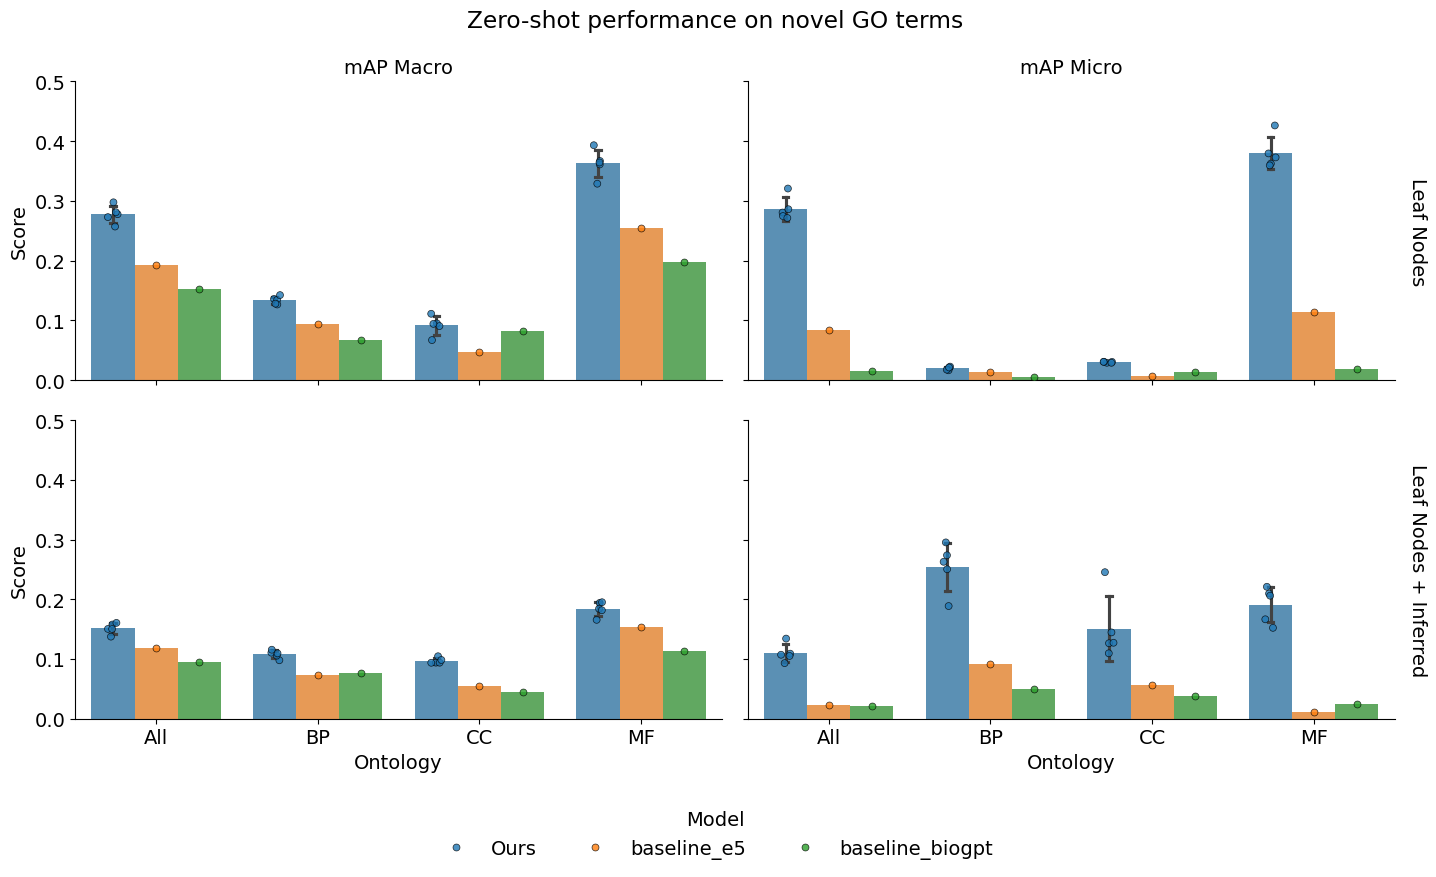

In [19]:
g = sns.FacetGrid(data = go_zs_final_metrics_df\
                    .melt(ignore_index=False,var_name=category_name,value_name='Score')\
                    .reset_index()\
                    .query('metric in ["mAP Macro","mAP Micro"]'),
                  row='test_name',
                  col='metric',
                  despine=True,
                  ylim=(0,0.5),
                  margin_titles=True,
                  height=4,
                  aspect=1.1,
                  row_order=['Leaf Nodes','Leaf Nodes + Inferred'])
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.figure.suptitle('Zero-shot performance on novel GO terms')
g.map_dataframe(sns.barplot,
                hue = 'model',
                errorbar='sd',
                capsize = 0.1,
                x=category_name,
                y='Score',
                alpha=0.8,
                palette = "tab10" )
g.map_dataframe(sns.stripplot,
                hue = 'model',
                edgecolor = 'black',
                linewidth=0.5,
                x=category_name,
                y='Score',
                alpha=0.8,
                palette = "tab10",
                dodge=True)
g.add_legend(title='Model', bbox_to_anchor=(0.5, 0), loc='upper center', ncol=3)
plt.tight_layout()
save_fig(name = '../outputs/figures/Detailed GO ZS')
plt.show()

Simplified Zero shot performance fig 4

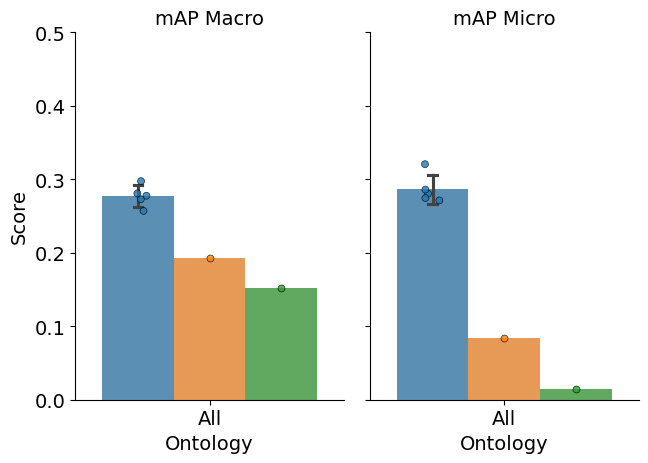

In [20]:
g = sns.FacetGrid(data = go_zs_final_metrics_df\
                    .melt(ignore_index=False,var_name=category_name,value_name='Score')\
                    .reset_index()\
                    .query('metric in ["mAP Macro","mAP Micro"] and Ontology == "All" and test_name == "Leaf Nodes"'),
                  col='metric',
                  despine=True,
                  ylim=(0,0.5),
                  margin_titles=True,
                  height=2.43*2,
                  aspect=.69,
                  row_order=['Leaf Nodes','Leaf Nodes + Inferred']
                  )
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.map_dataframe(sns.barplot,
                hue = 'model',
                errorbar='sd',
                capsize = 0.1,
                # err_kws={'linewidth':1.3},
                x=category_name,
                y='Score',
                alpha=0.8,
                palette = "tab10" )
g.map_dataframe(sns.stripplot,
                hue = 'model',
                edgecolor = 'black',
                linewidth=0.5,
                x=category_name,
                y='Score',
                alpha=0.8,
                palette = "tab10",
                dodge=True)
plt.tight_layout()
save_fig(name = '../outputs/figures/GO ZS')

### EC Zero Shot Performance (Figs S3 and 4)

Compute metrics for all models and datasets

In [21]:

test_sets = ['TEST_EC_DATA_PATH_ZERO_SHOT']
metrics = ['mAP Macro','mAP Micro']
ec_zs_final_metrics_df = []
threshold = 0.3
category_name = 'Top-level EC Class'
device = 'cuda'
for model in zero_shot_predictions.keys():
    for test_set in test_sets:
        if test_set not in zero_shot_predictions[model]:
            continue
        labels_df = zero_shot_labels[test_set][-1]
        test_name = zero_shot_labels[test_set][0]
        for logits_df in zero_shot_predictions[model][test_set]:
            metrics_df = metrics_by_ec_level_1(df_logits=logits_df,
                                            df_labels=labels_df,
                                            ec_class_descriptions=ec_class_descriptions,
                                            device=device,
                                            threshold=threshold)

            metrics_df = pd.DataFrame(metrics_df)
            metrics_df['model'] = model
            metrics_df['test_name'] = test_name
            metrics_df.index.name = 'metric'
            metrics_df = metrics_df.set_index(['model','test_name'],append=True)
            ec_zs_final_metrics_df.append(metrics_df)
ec_zs_final_metrics_df  = pd.concat(ec_zs_final_metrics_df)        

Detailed Zero Shot Performance (Fig S3)

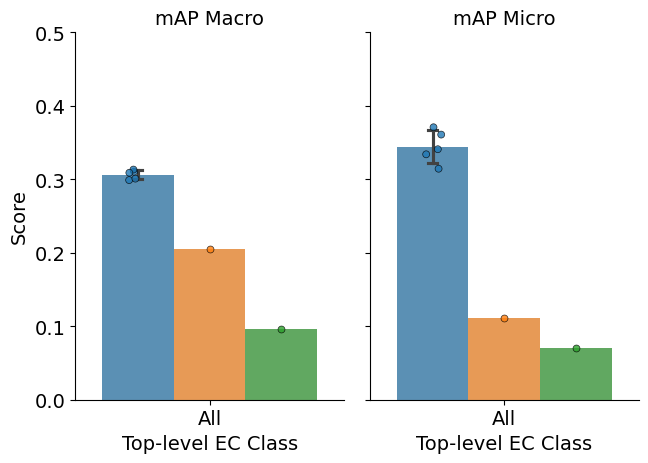

In [22]:
g = sns.FacetGrid(data = ec_zs_final_metrics_df[["All"]]\
                    .melt(ignore_index=False,var_name=category_name,value_name='Score')\
                    .reset_index()\
                    .query(f'metric in ["mAP Macro","mAP Micro"]'),
                  col='metric',
                  despine=True,
                  ylim=(0,0.5),
                  margin_titles=True,
                  height=2.43*2,
                  aspect=.69,
                  legend_out=True)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.map_dataframe(sns.barplot,
                hue = 'model',
                errorbar='sd',
                capsize = 0.1,
                x=category_name,
                y='Score',
                alpha=0.8,
                palette = "tab10" )
g.map_dataframe(sns.stripplot,
                hue = 'model',
                edgecolor = 'black',
                linewidth=0.5,
                x=category_name,
                y='Score',
                alpha=0.8,
                palette = "tab10",
                dodge=True)

plt.tight_layout()
save_fig(name = '../outputs/figures/EC ZS')


Simplified Zero Shot Performance Fig 4

/tmp/ipykernel_1745644/1427828866.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=60)
/tmp/ipykernel_1745644/1427828866.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=60)


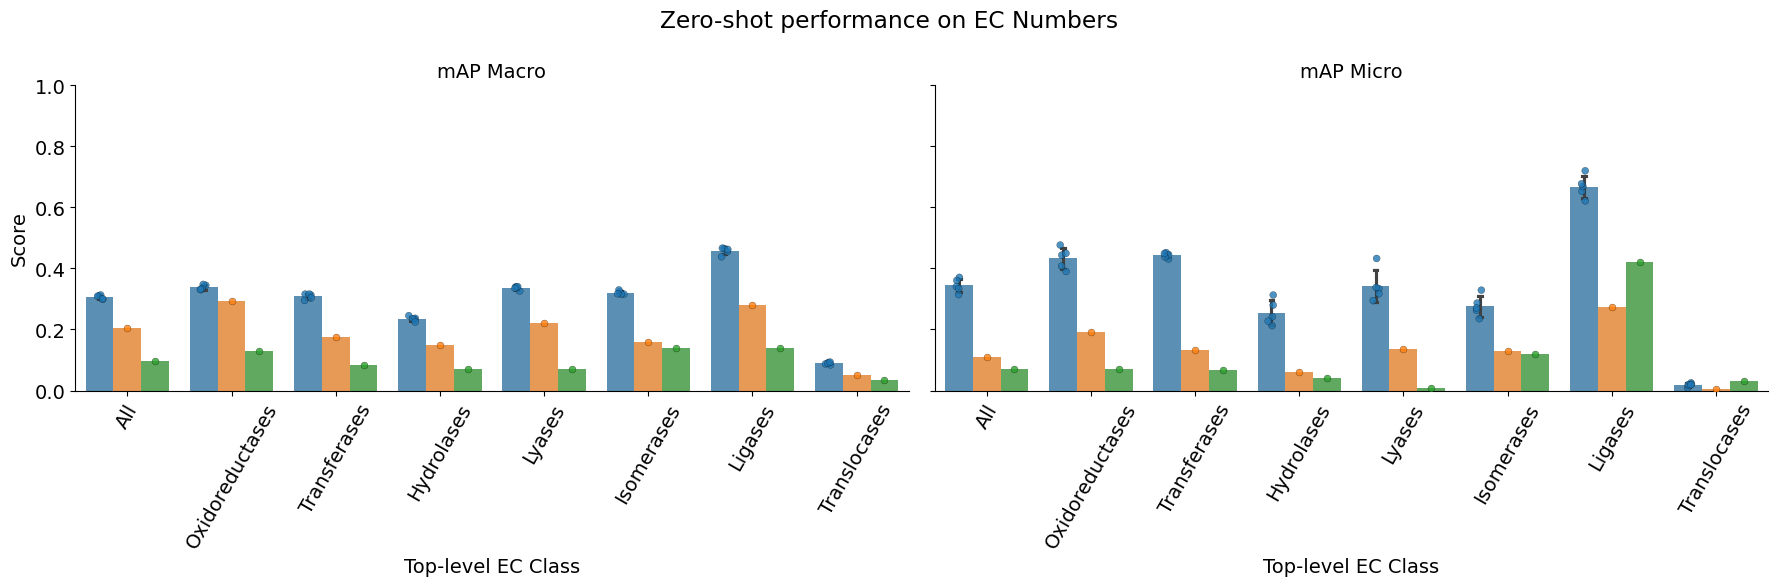

In [23]:

g = sns.FacetGrid(data = ec_zs_final_metrics_df\
                    .melt(ignore_index=False,var_name=category_name,value_name='Score')\
                    .reset_index()\
                    .query('metric in ["mAP Macro","mAP Micro"]'),
                  col='metric',
                  despine=True,
                  ylim=(0,1),
                  margin_titles=True,
                  height=6,
                  aspect=1.5,
                  legend_out=True)
g.figure.suptitle('Zero-shot performance on EC Numbers')
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.map_dataframe(sns.barplot,
                hue = 'model',
                errorbar='sd',
                capsize = 0.1,
                x=category_name,
                y='Score',
                alpha=0.8,
                palette = "tab10" )
g.map_dataframe(sns.stripplot,
                hue = 'model',
                edgecolor = 'black',
                linewidth=0.2,
                x=category_name,
                y='Score',
                alpha=0.8,
                palette = "tab10",
                dodge=True)
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=60)

plt.tight_layout()
save_fig(name = '../outputs/figures/Detailed EC ZS')


# Supervised Performance (Figs S2 and 2 )

In [2]:
supervised_final_metrics_df = pd.read_parquet('../outputs/results/supervised_metrics_df.parquet')

Simplified GO results (Fig 2)

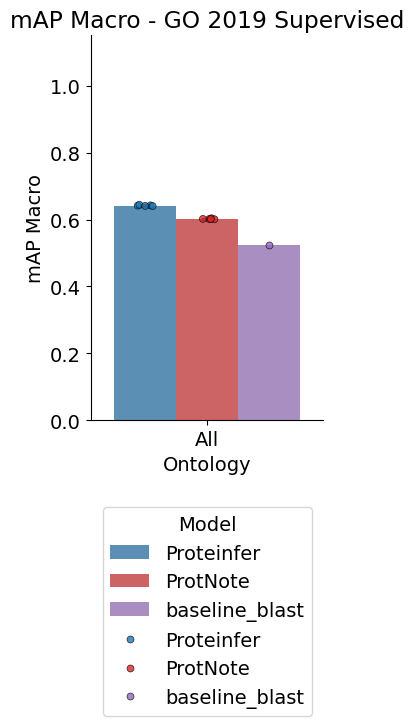

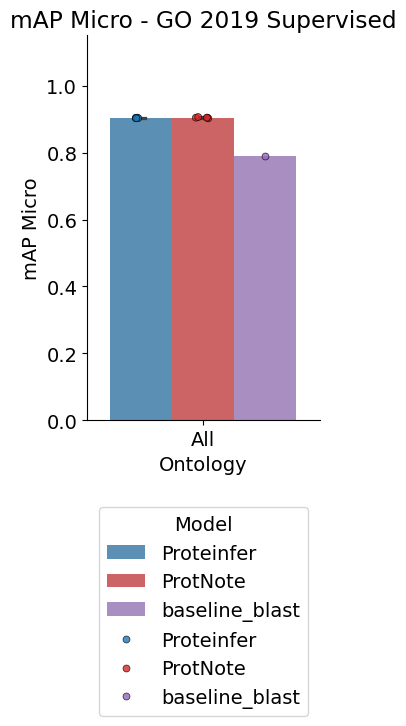

In [3]:
palette = sns.color_palette("tab10")
palette_ = palette[0:1] + palette[3:5]
test_name = 'GO 2019 Supervised'
for metric in ['mAP Macro','mAP Micro']:
    plot_category_performance(metrics_df = supervised_final_metrics_df[['All']],
                            test_name=test_name,
                            metric = metric,
                            category_name = 'Ontology',
                            ylim=(0,1.15),
                            figsize=(3,5),
                            palette=palette_,
                            name=f'../outputs/results/Supervised GO {metric}',
                            savefig=True
                            )
    

Detailed GO supervised results (Fig S2)

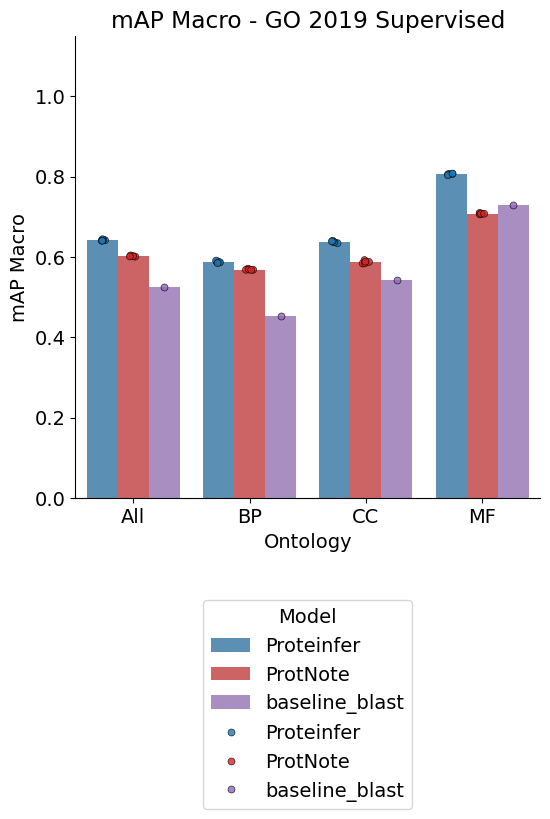

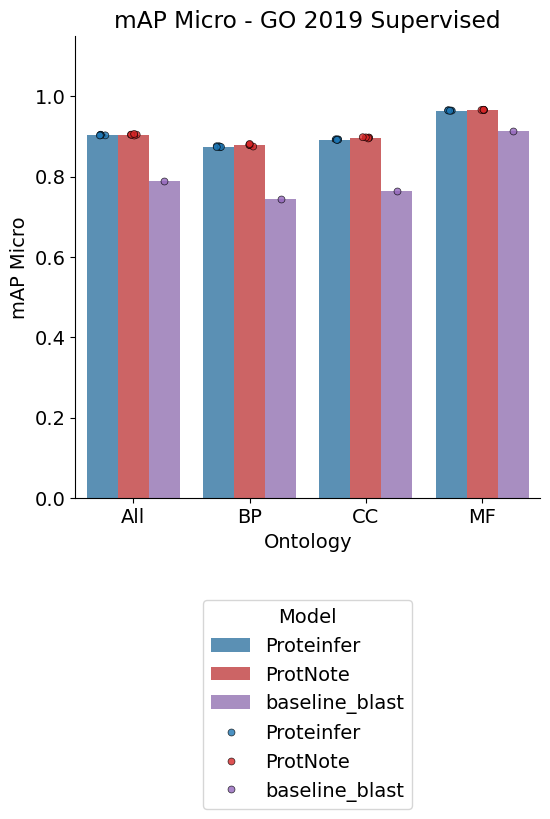

In [4]:
palette = sns.color_palette("tab10")
palette_ = palette[0:1] + palette[3:5]

for metric in ['mAP Macro','mAP Micro']:
    plot_category_performance(metrics_df = supervised_final_metrics_df,
                            test_name=test_name,
                            metric = metric,
                            category_name = 'Ontology',
                            ylim=(0,1.15),
                            name=f'../outputs/results/Detailed Supervised GO {metric}',
                            palette=palette_,
                            figsize=(3*2,3*2),
                            savefig=True
                            )


Welchl's t-tests

In [ ]:
supervised_final_metrics_df

In [10]:
supervised_final_metrics_df.groupby(['model','metric','test_name']).mean()

All        BP        CC  \
model          metric    test_name                                          
ProtNote       f1_macro  GO 2019 Supervised  0.551127  0.535811  0.523817   
               f1_micro  GO 2019 Supervised  0.870390  0.847703  0.846408   
               mAP Macro GO 2019 Supervised  0.601860  0.568673  0.587246   
               mAP Micro GO 2019 Supervised  0.904225  0.878570  0.896922   
Proteinfer     f1_macro  GO 2019 Supervised  0.560058  0.510630  0.548306   
               f1_micro  GO 2019 Supervised  0.867997  0.841850  0.844140   
               mAP Macro GO 2019 Supervised  0.641767  0.587680  0.637544   
               mAP Micro GO 2019 Supervised  0.903250  0.874319  0.892166   
baseline_blast f1_macro  GO 2019 Supervised  0.634218  0.577703  0.656223   
               f1_micro  GO 2019 Supervised  0.888471  0.862460  0.873343   
               mAP Macro GO 2019 Supervised  0.524891  0.454061  0.543823   
               mAP Micro GO 2019 Supervised  0.789926  0.744487  0.763380   

                                                   MF  
model          metric    test_name                     
ProtNote       f1_macro  GO 2019 Supervised  0.608688  
               f1_micro  GO 2019 Supervised  0.933389  
               mAP Macro GO 2019 Supervised  0.707727  
               mAP Micro GO 2019 Supervised  0.966006  
Proteinfer     f1_macro  GO 2019 Supervised  0.713346  
               f1_micro  GO 2019 Supervised  0.937299  
               mAP Macro GO 2019 Supervised  0.805943  
               mAP Micro GO 2019 Supervised  0.964496  
baseline_blast f1_macro  GO 2019 Supervised  0.794516  
               f1_micro  GO 2019 Supervised  0.955068  
               mAP Macro GO 2019 Supervised  0.729248  
               mAP Micro GO 2019 Supervised  0.912427

In [11]:
t_test_results = []
for ontology,metric in product(['All','BP','CC','MF'],['mAP Macro','mAP Micro']):
    
    filtered_data = supervised_final_metrics_df.query('metric==@metric')[[ontology]]
    sample = filtered_data.query('model=="ProtNote"').values

    baseline_models = ['Proteinfer']
    for baseline_model in baseline_models:
        sample_b = filtered_data.query('model==@baseline_model').values

        t_test_res = ttest_ind(a = sample,b=sample_b,equal_var=False) 
        
        t_test_results.append({'ontology':ontology,
         'metric':metric,
         'model':baseline_model,
         'model avg score':sample_b.mean(),
         'model std score':sample_b.std(),
         'ProtNote avg score':sample.mean(),
         'ProtNote std score':sample.std(),
         't_test_pvalue':t_test_res.pvalue[0]
        })
t_test_results = pd.DataFrame.from_records(t_test_results)
t_test_results = t_test_results.sort_values(by=['model','ontology','metric']).set_index(['ontology','metric','model'])
t_test_results['significant'] = t_test_results['t_test_pvalue']<0.05
t_test_results

model avg score  model std score  \
ontology metric    model                                          
All      mAP Macro Proteinfer         0.641767         0.001364   
         mAP Micro Proteinfer         0.903250         0.000755   
BP       mAP Macro Proteinfer         0.587680         0.002060   
         mAP Micro Proteinfer         0.874319         0.001100   
CC       mAP Macro Proteinfer         0.637544         0.001970   
         mAP Micro Proteinfer         0.892166         0.000579   
MF       mAP Macro Proteinfer         0.805943         0.001417   
         mAP Micro Proteinfer         0.964496         0.000518   

                               ProtNote avg score  ProtNote std score  \
ontology metric    model                                                
All      mAP Macro Proteinfer            0.601860            0.001015   
         mAP Micro Proteinfer            0.904225            0.001267   
BP       mAP Macro Proteinfer            0.568673            0.001083   
         mAP Micro Proteinfer            0.878570            0.002114   
CC       mAP Macro Proteinfer            0.587246            0.003071   
         mAP Micro Proteinfer            0.896922            0.001097   
MF       mAP Macro Proteinfer            0.707727            0.001180   
         mAP Micro Proteinfer            0.966006            0.000326   

                               t_test_pvalue  significant  
ontology metric    model                                   
All      mAP Macro Proteinfer   2.022268e-10         True  
         mAP Micro Proteinfer   2.303533e-01        False  
BP       mAP Macro Proteinfer   3.092224e-06         True  
         mAP Micro Proteinfer   1.174688e-02         True  
CC       mAP Macro Proteinfer   3.027310e-08         True  
         mAP Micro Proteinfer   2.430021e-04         True  
MF       mAP Macro Proteinfer   1.517564e-13         True  
         mAP Micro Proteinfer   1.887353e-03         True

# Ablations

Read, parse and clean ablated model predictions

In [30]:
dataset_alias_to_name={'Leaf Nodes':'TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES',
                        'Leaf Nodes + Inferred':'TEST_DATA_PATH_ZERO_SHOT',
                        'EC Zero Shot':'TEST_EC_DATA_PATH_ZERO_SHOT',
                        'GO 2019 Supervised':'VAL_DATA_PATH'}

test_ablations = pd.read_json('../outputs/results/final_model_ablations.json')
test_ablations['dataset_name'] = test_ablations['name'].apply(lambda x: x.split('_2024')[0])
test_ablations['model'] = test_ablations['name'].apply(lambda x: re.findall('SEED_42_(.+)_SEQUENCE_WEIGHT',x)[0]  if len(re.findall('SEED_42_(.+)_SEQUENCE_WEIGHT',x)) >0 else np.nan)

test_ablations.dropna(inplace=True)
ablation_order = test_ablations.query('dataset_name=="TEST_DATA_PATH_ZERO_SHOT"').sort_values(by='test_1_map_macro',ascending=False)['model'].tolist()

test_ablations['model'] = test_ablations['model'].astype("category")
test_ablations['model'] = test_ablations['model'].cat.set_categories(ablation_order)
test_ablations.columns = [i.replace('test_1_','') for i in test_ablations.columns]

protnote_perfs = []
for perf_df in [go_zs_final_metrics_df,ec_zs_final_metrics_df,supervised_final_metrics_df]:
    temp = perf_df.query(
        'model=="Ours"'
    )['All'].reset_index(
    ).replace(
        dataset_alias_to_name
    ).drop(
        ['model'],axis=1
    )
    
    temp = temp.assign(
        seed=(np.arange(len(temp),dtype=int)//4)%5 #divide by 4 because of the number of metrics
    ).pivot(
        index=['test_name','seed'],
        columns='metric'
    )
    temp.columns = [i[-1].lower().replace(' ','_')  for i in temp.columns]
    
    temp = temp.droplevel(
        'seed'
    ).reset_index(
    ).rename(
        columns={'test_name':'dataset_name'}
    ).assign(model='ProtNote')

    protnote_perfs.append(temp)

test_ablations = pd.concat([test_ablations,*protnote_perfs],axis=0,ignore_index=True)

/tmp/ipykernel_3863656/3103945698.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(errorbar='sd',
/tmp/ipykernel_3863656/3103945698.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
/tmp/ipykernel_3863656/3103945698.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(errorbar='sd',
/tmp/ipykernel_3863656/3103945698.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


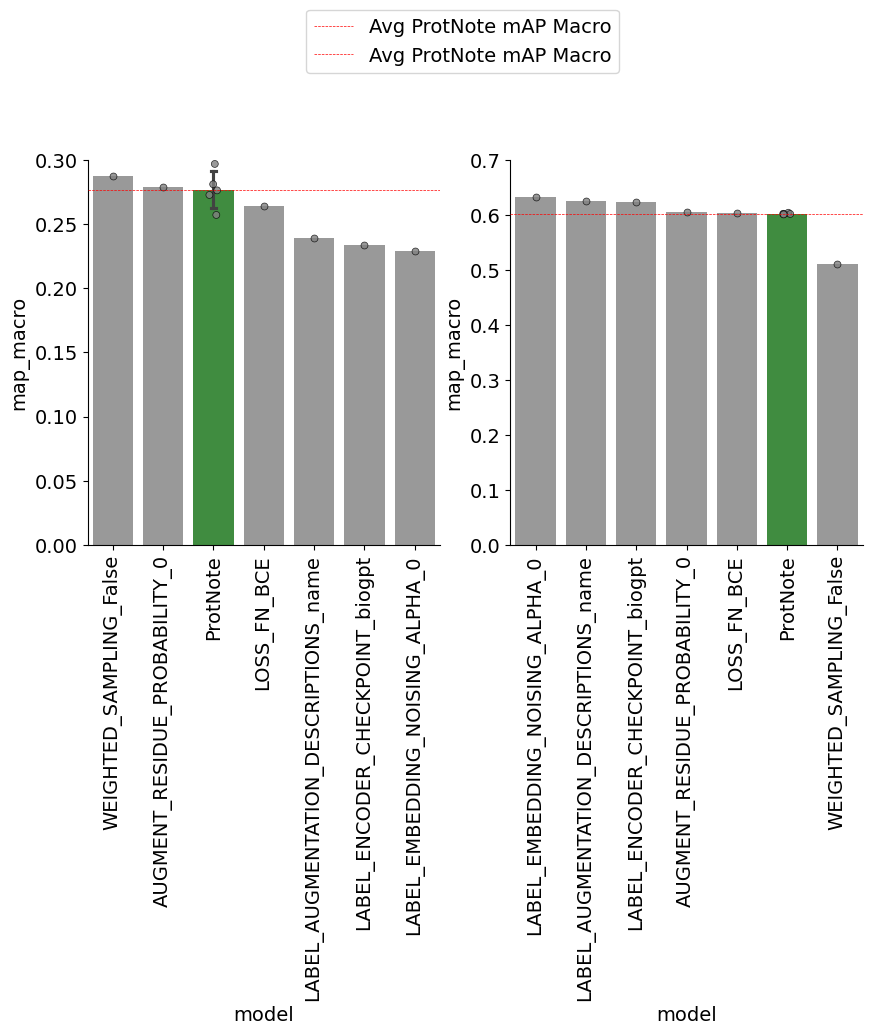

In [67]:

fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(10,5),sharey=False)

test_ablations.groupby(['dataset_name','model'])[['map_macro']].mean()
for idx,dataset_name in enumerate(["TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES","VAL_DATA_PATH"]):
    test_ablations_plot = test_ablations.query('dataset_name ==@dataset_name').sort_values(by='map_macro',ascending=False)
    
    best_models = test_ablations_plot.groupby(['model'])[['map_macro']].mean().reset_index().sort_values(by='map_macro',ascending=False)
    palette = ['green' if m=='ProtNote' else 'grey' for m in best_models["model"].tolist()]

    sns.barplot(errorbar='sd',
                capsize = 0.1,
                # err_kws={'linewidth':1.3},
                data = test_ablations_plot,
                x='model',
                y='map_macro',
                alpha=0.8,
                palette = palette,
                ax=axes[idx],
                order=best_models['model']
                )
    
    sns.stripplot(
                edgecolor = 'black',
                linewidth=0.5,
                x='model',
                y='map_macro',
                data = test_ablations_plot,
                alpha=0.8,
                palette = ["grey"]*len(best_models),
                # dodge=True,
                ax=axes[idx],
                order=best_models['model']
                )

    axes[idx].axhline(y=test_ablations_plot.query('model=="ProtNote"')['map_macro'].mean(),
                color='red',
                linestyle='--',
                linewidth=0.5,
                zorder=3,
                label='Avg ProtNote mAP Macro'
                )

    ylim= (0,0.3) if dataset_name == "TEST_DATA_PATH_ZERO_SHOT_LEAF_NODES" else (0,0.7)
    axes[idx].set_ylim(*ylim)
    axes[idx].tick_params(axis='x', rotation=90)

sns.despine()
# fig.legend()
fig.legend(markerscale=1, bbox_to_anchor=(0.5, 1.2), loc='upper center')
save_fig('../outputs/figures/ablations')
plt.show()


# BLAST vs ProtNote runtimes

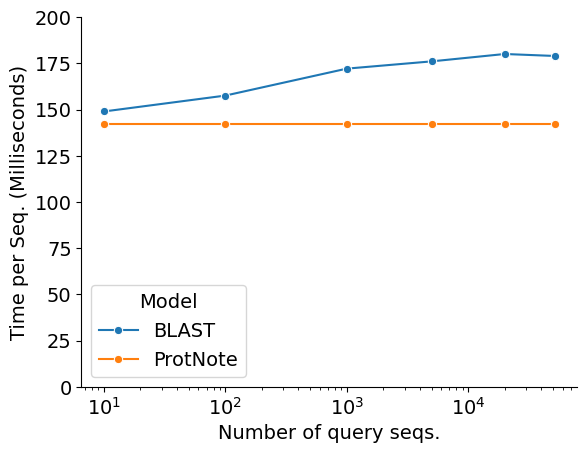

In [12]:
runtimes = pd.read_excel('../outputs/results/blast runtime.xlsx',sheet_name='merged')
runtimes = runtimes.rename(columns={'BLAST seqs per minute':'BLAST',
                         'ProtNote seqs per minute':'ProtNote',
                         'Num Query Seqs':'Number of query seqs.'}).melt(id_vars=['Number of query seqs.'],
              value_vars=['BLAST','ProtNote'],
              value_name='Seqs. per minute',
              var_name='Model')
runtimes['Time per Seq. (Milliseconds)'] = 60*1000/runtimes['Seqs. per minute']

sns.lineplot(data = runtimes, x  = 'Number of query seqs.',y='Time per Seq. (Milliseconds)',hue='Model',marker='o')
plt.ylim(0,200)
sns.despine()
plt.xscale('log')
save_fig('../outputs/figures/runtimes')


## Impact of GO graph change

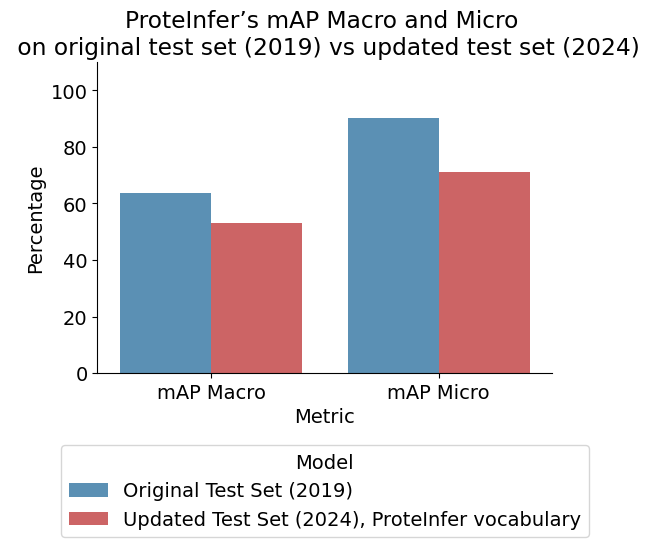

In [5]:

data = {
    'Metric': ['mAP Macro', 'mAP Micro'],
    'Original Test Set (2019)': [63.79, 90.26],
    'Updated Test Set (2024), ProteInfer vocabulary': [53.03, 71.19]
}

df = pd.DataFrame(data)

palette = sns.color_palette("tab10")
palette_ = palette[0:1] + palette[3:4]
fig,ax = plt.subplots(figsize=(6, 6))
sns.barplot(data=df.melt(id_vars=['Metric'],
                 value_vars=['Original Test Set (2019)','Updated Test Set (2024), ProteInfer vocabulary'],
                 value_name='Percentage',
                 var_name='Test Set'),
            x = 'Metric',
            y='Percentage',
            hue='Test Set',
            alpha=0.8,
            palette = palette_,
            ax=ax
            )

plt.ylim(0,110)
plt.title('ProteInfer’s mAP Macro and Micro \n on original test set (2019) vs updated test set (2024)')
sns.despine()
plt.legend(title='Model', bbox_to_anchor=(0.5, -0.2), loc='upper center')
plt.tight_layout()
save_fig('../outputs/figures/impact_of_go_graph_change')
plt.show()
